## Self Attention Model
\begin{align}
Q &= X W^Q, \\
K &= X W^K, \\
V &= X W^V, \\
\text{Attention}(Q, K, V) 
  &= \operatorname{Softmax}\!\left(\frac{QK^\top}{\sqrt{d_k}}\right)V.
\end{align}

\begin{align}
\text{MultiHead}(X) 
  &= \text{Concat}\big(\text{head}_1, \ldots, \text{head}_h\big) W^O, \\
\text{head}_i 
  &= \operatorname{Attention}(X W_i^Q, X W_i^K, X W_i^V).
\end{align}


In [1]:
import torch
import torch.nn as nn
class myselfattention(nn.Module):
    def __init__(self, d_in, d_out,context_length,bias=True):
        super().__init__()
        self.W_value=nn.Linear(d_in,d_out,bias=bias)
        self.W_query=nn.Linear(d_in,d_out,bias=bias)
        self.W_key=nn.Linear(d_in,d_out,bias=bias)
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1)) # New
    def forward(self, x): 
        _,num_tokens,_=x.shape
        value=self.W_value(x)
        query=self.W_query(x)
        key=self.W_key(x)
        attn_scores=query@key.mT
        attn_scores.masked_fill_(self.mask.bool()[:num_tokens, :num_tokens], -torch.inf)      
        return nn.Softmax(dim=-1)(attn_scores/key.shape[-1]**0.5)@value
myattention=myselfattention(4,4,3)
input=torch.rand(2,3,4)
output=myattention(input)
print(f"output size is: {output.shape}")

output size is: torch.Size([2, 3, 4])


In [2]:
class myselfattention_mh(nn.Module):
    def __init__(self, d_in, d_head, d_out,context_length,bias=True):
        super().__init__()
        self.heads=nn.ModuleList([myselfattention(d_in, d_out//d_head, context_length) for _ in range(d_head)])
        self.W_out=nn.Linear(d_out,d_out,bias)
    def forward(self, x): 
        out=torch.cat([self.heads[i](x) for i in range(len(self.heads))], dim=-1)
        return self.W_out(out)

In [3]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(myselfattention_mh(16,8,16,7))

1088

In [4]:
class mySilu(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x): 
        return 0.5*x*(1+torch.tanh(torch.sqrt(torch.tensor(2/torch.pi))*(x+0.044715*x**3)))

In [5]:
class ffn(nn.Module):
    def __init__(self,dim,dropout=0.1,bias=True):
        super().__init__()
        self.W1=nn.Linear(dim,4*dim,bias)
        self.W2=nn.Linear(4*dim,dim,bias)
        self.dropout=nn.Dropout(dropout)
        self.silu=mySilu()
    def forward(self, x): 
        return self.dropout(self.W2(self.silu(self.W1(x))))

In [6]:
class myTransformer(nn.Module):
    def __init__(self, heads, dropout, hidden,context_length,bias=True):
        super().__init__()
        self.myselfattention_mh=myselfattention_mh(hidden,heads,hidden,context_length)#nn.ModuleList([myselfattention(d_in, d_head) for _ in range(d_out//d_head)])
        self.layernorm1=nn.LayerNorm(hidden)
        self.layernorm2=nn.LayerNorm(hidden)
        self.ffn=ffn(hidden,dropout,bias)
        self.dropout=dropout
    def forward(self, x): 
        shortcut1=x;
        x=self.layernorm1(x)
        x=self.myselfattention_mh(x)
        x=nn.Dropout(self.dropout)(x)
        x=x+shortcut1
        shortcut2=x;
        x=self.layernorm2(x)
        x=self.ffn(x)
        x=nn.Dropout(self.dropout)(x)
        x=x+shortcut2
        return x

In [7]:
cfg={
    "layers": 12,
    "heads": 12,
    "dropout": 0.1,
    "context_length": 1024,
    "hidden_dim": 768,
    "voc_size": 50257
}
class myGPT2(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers=cfg["layers"]
        self.heads=cfg["heads"]
        self.dropout=cfg["dropout"]
        self.context_length=cfg["context_length"]
        self.hidden_dim=cfg["hidden_dim"]
        self.voc_size=cfg["voc_size"]
        self.wte=nn.Embedding(self.voc_size,self.hidden_dim)
        self.wpe=nn.Embedding(self.context_length,self.hidden_dim)
        self.layernorm=nn.LayerNorm(self.hidden_dim)
        self.linear=nn.Linear(self.hidden_dim,self.voc_size,bias=False)
        self.transformerBlocks=nn.ModuleList([myTransformer(self.heads,self.dropout,self.hidden_dim,self.context_length) for _ in range(self.layers)])
    def forward(self, x): 
        batch,length=x.shape
        te=self.wte(x);
        pe=self.wpe(torch.arange(length, device=x.device));
        x=te+pe;
        x=nn.Dropout(self.dropout)(x)
        x=nn.Sequential(*self.transformerBlocks)(x)
        x=self.layernorm(x)
        x=self.linear(x)
        return x

In [8]:
x=torch.tensor([[1, 2, 3], [4, 5, 6]])
model=myGPT2(cfg)
model(x).shape

torch.Size([2, 3, 50257])

In [9]:
count_parameters(model)

163037184

In [10]:
input_text1="I study at Clemson"
input_text2="I am a student"
input = [input_text1,input_text2]
import tiktoken

# Load GPT-2 tokenizer
enc = tiktoken.get_encoding("gpt2")

##TODO: how to get the tokens of input
tokens = [enc.encode(text) for text in input]


In [11]:
tokens

[[40, 2050, 379, 27801], [40, 716, 257, 3710]]

In [12]:
model(torch.tensor(tokens)).shape

torch.Size([2, 4, 50257])

In [13]:
def generate(model,tokens,max_length):
    for i in range(max_length):
        with torch.no_grad():
            x=model(tokens)
        ##TODO: return the generation with max_length limit
        logits=x[:,-1,:]
        _,idx=torch.max(logits, dim=-1, keepdim=True)
        tokens=torch.cat((tokens, idx), dim=1)
    return tokens
generated=generate(model,torch.tensor(tokens),6)

In [14]:
generated

tensor([[   40,  2050,   379, 27801, 32070, 16173, 16560, 11995, 46295, 49965],
        [   40,   716,   257,  3710, 44535, 13704,  1561, 21770, 45863, 26735]])

In [15]:
for i, seq in enumerate(generated.tolist()):
    text = enc.decode(seq)
    print(f"Sequence {i}: {text}")

Sequence 0: I study at Clemson hepat interpreted incorporated Dungeon Chandra GAM
Sequence 1: I am a student Visitorsoshi talk Baron deliberations pedestrians


In [16]:
enc.encode(text)

[40, 716, 257, 3710, 44535, 13704, 1561, 21770, 45863, 26735]

In [17]:
import os
import requests

/home/kail/.conda/envs/myenv/lib/python3.10/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [18]:
file_path = "small.txt"
with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()

In [19]:
print(text_data[:99])

﻿The Project Gutenberg eBook of Two Centuries of Costume in America, Vol. 1 (1620-1820), by Alice M


In [20]:
print(text_data[-99:])

help produce our new eBooks, and how to
subscribe to our email newsletter to hear about new eBooks.


In [21]:
total_characters = len(text_data)
total_tokens = len(enc.encode(text_data,disallowed_special=()))


print("Characters:", total_characters)
print("Tokens:", total_tokens)


Characters: 527230
Tokens: 140584


In [22]:
from previous_chapters import create_dataloader_v1

# Train/validation ratio
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]


torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=cfg["context_length"],
    stride=cfg["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=cfg["context_length"],
    stride=cfg["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [23]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)
    break

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)
    break

Train loader:
torch.Size([2, 1024]) torch.Size([2, 1024])

Validation loader:
torch.Size([2, 1024]) torch.Size([2, 1024])


In [24]:
x[0,:10]

tensor([3856, 1000,  468,  530,   26,  475,  198, 4480,  262, 1049])

In [25]:
y[0,:10]

tensor([1000,  468,  530,   26,  475,  198, 4480,  262, 1049, 2478])

This makes sense as we discussed in class that the output response is just 1 stride increase of the input.

In [26]:
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Training tokens: 124928
Validation tokens: 13312
All tokens: 138240


In [27]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch=input_batch.to(device)
    target_batch=target_batch.to(device)
    prediction=model(input_batch)
    return torch.nn.functional.cross_entropy(prediction.flatten(0, 1), target_batch.flatten())
    ##TODO: calculate batch loss

In [28]:
def calc_loss_loader(data_loader, model, device,num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            total_loss += calc_loss_batch(input_batch, target_batch, model, device).item()
            ##TODO: calculate total_loss which will call function calc_loss_batch defined above
        else:
            break
    return total_loss / num_batches

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device) 
torch.manual_seed(123) 
with torch.no_grad(): 
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.991145993842453
Validation loss: 10.99047783442906


In [30]:
from previous_chapters import generate_text_simple
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.wpe.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

In [31]:
import time
start_time = time.time()

torch.manual_seed(123)
model = myGPT2(cfg)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 4
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=enc
)

# Note:
# Uncomment the following code to show the execution time
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 9.876, Val loss 9.827
Ep 1 (Step 000005): Train loss 8.321, Val loss 8.392
Ep 1 (Step 000010): Train loss 7.414, Val loss 7.620
Ep 1 (Step 000015): Train loss 7.083, Val loss 7.391
Ep 1 (Step 000020): Train loss 7.104, Val loss 7.377
Ep 1 (Step 000025): Train loss 6.838, Val loss 7.341
Ep 1 (Step 000030): Train loss 6.971, Val loss 7.145
Ep 1 (Step 000035): Train loss 6.650, Val loss 7.101
Ep 1 (Step 000040): Train loss 6.685, Val loss 6.991
Ep 1 (Step 000045): Train loss 6.557, Val loss 6.941
Ep 1 (Step 000050): Train loss 6.470, Val loss 6.871
Ep 1 (Step 000055): Train loss 6.355, Val loss 6.833
Ep 1 (Step 000060): Train loss 6.375, Val loss 6.782
Every effort moves you                                                  
Ep 2 (Step 000065): Train loss 6.426, Val loss 6.762
Ep 2 (Step 000070): Train loss 6.351, Val loss 6.749
Ep 2 (Step 000075): Train loss 6.228, Val loss 6.729
Ep 2 (Step 000080): Train loss 6.257, Val loss 6.758
Ep 2 (Step 000085): Train 

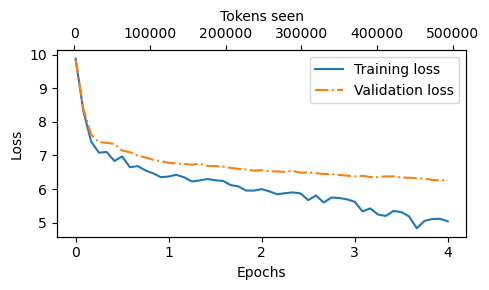

In [32]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [33]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # New (not in book): numerical stability tip to get equivalent results on mps device
            # subtract rowwise max before softmax
            logits = logits - logits.max(dim=-1, keepdim=True).values
            
            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

In [34]:
torch.manual_seed(123)
inference_device = torch.device("cpu")

model.to(inference_device)
model.eval()

token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", enc).to(inference_device),
    max_new_tokens=15,
    context_size=cfg["context_length"],
    top_k=25,
    temperature=1.4
)

print("Output text:\n", token_ids_to_text(token_ids, enc))

Output text:
 Every effort moves you-s, “Hman. For some his own
And a


In [35]:
from gpt_download import download_and_load_gpt2

2025-10-23 21:33:03.498280: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [36]:
settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")

File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


In [37]:
print(list(params.keys()))

['blocks', 'b', 'g', 'wpe', 'wte']


In [38]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

In [43]:
import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.wpe.weight = assign(gpt.wpe.weight, params['wpe'])
    gpt.wte.weight = assign(gpt.wte.weight, params['wte'])
    
    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        # print(f"q_w size is: {q_w.shape}")
        # print(f"k_w size is: {k_w.shape}")
        # print(f"v_w size is: {v_w.shape}")
        for h in range(cfg["heads"]):
            # print(f"{gpt.transformerBlocks[b].myselfattention_mh.heads[h].W_query.weight.shape}")
            gpt.transformerBlocks[b].myselfattention_mh.heads[h].W_query.weight = assign(
                gpt.transformerBlocks[b].myselfattention_mh.heads[h].W_query.weight, torch.chunk(torch.tensor(q_w.T), cfg["heads"], dim=0)[h])
            gpt.transformerBlocks[b].myselfattention_mh.heads[h].W_key.weight = assign(
                gpt.transformerBlocks[b].myselfattention_mh.heads[h].W_key.weight, torch.chunk(torch.tensor(k_w.T), cfg["heads"], dim=0)[h])
            gpt.transformerBlocks[b].myselfattention_mh.heads[h].W_value.weight = assign(
                gpt.transformerBlocks[b].myselfattention_mh.heads[h].W_value.weight, torch.chunk(torch.tensor(v_w.T), cfg["heads"], dim=0)[h])
            gpt.transformerBlocks[b].myselfattention_mh.heads[h].W_query.bias = assign(
                gpt.transformerBlocks[b].myselfattention_mh.heads[h].W_query.bias, torch.chunk(torch.tensor(q_b), cfg["heads"], dim=0)[h])
            gpt.transformerBlocks[b].myselfattention_mh.heads[h].W_key.bias = assign(
                gpt.transformerBlocks[b].myselfattention_mh.heads[h].W_key.bias, torch.chunk(torch.tensor(k_b), cfg["heads"], dim=0)[h])
            gpt.transformerBlocks[b].myselfattention_mh.heads[h].W_value.bias = assign(
                gpt.transformerBlocks[b].myselfattention_mh.heads[h].W_value.bias, torch.chunk(torch.tensor(v_b), cfg["heads"], dim=0)[h])
            
        
        #print(f"q_b size is: {q_b.shape}")
        

        gpt.transformerBlocks[b].myselfattention_mh.W_out.weight = assign(
            gpt.transformerBlocks[b].myselfattention_mh.W_out.weight, 
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.transformerBlocks[b].myselfattention_mh.W_out.bias = assign(
            gpt.transformerBlocks[b].myselfattention_mh.W_out.bias, 
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.transformerBlocks[b].ffn.W1.weight = assign(
            gpt.transformerBlocks[b].ffn.W1.weight, 
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.transformerBlocks[b].ffn.W1.bias = assign(
            gpt.transformerBlocks[b].ffn.W1.bias, 
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        # gpt.trf_blocks[b].ff.layers[0].bias = assign(
        #     gpt.trf_blocks[b].ff.layers[0].bias, 
        #     params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.transformerBlocks[b].ffn.W2.weight = assign(
            gpt.transformerBlocks[b].ffn.W2.weight, 
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.transformerBlocks[b].ffn.W2.bias = assign(
            gpt.transformerBlocks[b].ffn.W2.bias, 
            params["blocks"][b]["mlp"]["c_proj"]["b"])
        # gpt.trf_blocks[b].ff.layers[2].bias = assign(
        #     gpt.trf_blocks[b].ff.layers[2].bias, 
        #     params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.transformerBlocks[b].layernorm1.weight = assign(
            gpt.transformerBlocks[b].layernorm1.weight, 
            params["blocks"][b]["ln_1"]["g"])
        gpt.transformerBlocks[b].layernorm1.bias = assign(
            gpt.transformerBlocks[b].layernorm1.bias, 
            params["blocks"][b]["ln_1"]["b"])
        gpt.transformerBlocks[b].layernorm2.weight = assign(
            gpt.transformerBlocks[b].layernorm1.weight, 
            params["blocks"][b]["ln_2"]["g"])
        gpt.transformerBlocks[b].layernorm2.bias = assign(
            gpt.transformerBlocks[b].layernorm1.bias, 
            params["blocks"][b]["ln_2"]["b"])

    gpt.layernorm.weight = assign(gpt.layernorm.weight, params["g"])
    gpt.layernorm.bias = assign(gpt.layernorm.bias, params["b"])
    gpt.linear.weight = assign(gpt.linear.weight, params["wte"])
    
    
load_weights_into_gpt(model, params)
model.to(device);
model.eval();

/local_scratch/slurm.6579593/ipykernel_2325724/1629613674.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.nn.Parameter(torch.tensor(right))


In [44]:
torch.manual_seed(12345)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", enc).to(device),
    max_new_tokens=25,
    context_size=cfg["context_length"],
    top_k=50,
    temperature=1.5
)

print("Output text:\n", token_ids_to_text(token_ids, enc))

Output text:
 Every effort moves you towards yourself. As an adult, one of your first jobs must be in some way of life: to survive and care for
